### Loading Dataset

In [1]:
setwd('/fs/cbcb-lab/rob/students/noor/Uncertainity/treeTerminusScripts')
suppressPackageStartupMessages(source("tree_helper_function.R"))
suppressPackageStartupMessages(source("tree_term_climb.R"))
suppressPackageStartupMessages(library(beaveR))
suppressPackageStartupMessages(library(TreeSummarizedExperiment))

saveDir <- "environment/Chimp/DE"
load(file.path(saveDir, "tseChimp.RData"))
load(file.path(saveDir, "yAll.RData"))
load(file.path(saveDir, "y.RData"))
load(file.path(saveDir, "yg.RData"))
load(file.path(saveDir, "bSwishConsFDR_OL.RData"))
treeCons <- rowTree(tseChimp)
nleaves <- length(treeCons$tip)

#### Transcript level analysis

In [4]:
sum(mcols(y)[["keep"]])
sum(mcols(yAll)[["keep"]])
sum(mcols(y)[["pvalue"]] < 0.1, na.rm=T)
sum(mcols(yAll)[treeCons$tip.label,"pvalue"] < 0.1, na.rm=T)

sum(mcols(y)[["qvalue"]] < 0.1, na.rm=T)
sum(mcols(yAll)[treeCons$tip.label,"qvalue"] < 0.1, na.rm=T)

[1] 25236

[1] 49951

[1] 13831

[1] 13496

[1] 11886

[1] 11813

##### Differentially Expressed Transcripts

In [5]:
sapply(c(0.01,0.05,0.1), function(x) sum(mcols(y)[["qvalue"]] <= x, na.rm=T))
dTxps <- lapply(c(0.01,0.05,0.1), function(x) rownames(y)[which(mcols(y)[["qvalue"]] <= x)])

[1]  3539 10133 11886

##### Genes Mapping to those transcripts

In [6]:
mapDf <- rowData(tseChimp)
txpGenes <- lapply(dTxps, function(txps) unique(unlist(mapDf[txps, "GENEID"])))##Genes that map to transcripts
sapply(txpGenes, length)

[1] 3236 8304 9492

#### Gene Level

##### Differentially expressed genes

In [7]:
dges <- lapply(c(0.01,0.05,0.1), function(x) rownames(yg)[which(mcols(yg)[["qvalue"]] <= x)])
sapply(dges, length)

[1] 6090 8256 9354

### Genes that are considered differentially expressed in gene level analysis but don't contain a single differentially expressed transcript

In [8]:
diffGenes <- lapply(seq_along(dges), function(i) setdiff(dges[[i]], txpGenes[[i]])) ## dges that are mapped by genes but not by differential transcripts
sapply(diffGenes, length)
diffGenes2 <- lapply(seq_along(dges), function(i) setdiff(txpGenes[[i]], dges[[i]])) ## Genes that are mapped to differential transcripts but not mapped by genes
sapply(diffGenes2, length)
# sum(mcols(y)[unlist(mcols(yg)[diffGenes[[2]],"tx_ids"]), "qvalue"] < 0.05, na.rm=T)==0 ## None of the diffGenes should contain a differential transcript

[1] 2984  787  716

[1] 130 835 854

#### TreeDE, with the total number of nodes, inner nodes and their height distribution

In [2]:
load(file.path(saveDir, "treeDEFDR_OL.RData"))
treeDE <- treeDEFDR_OL[["mIRV=0.4"]] ## renaming the treeDE variable
sapply(treeDE, length) ## number of differentially expressed nodes
sapply(treeDE, function(nodes) sum(nodes > nleaves)) ## number of inner nodes
lapply(treeDE, function(nodes) table(node.depth(treeCons,2)[nodes])) ## Distribution of node heights

[1]  4001 10247 12017

[1] 1280 2268 2745

[[1]]

   1    2    3    4    5    6    7    8    9   10 
2721  705  342  126   70   18   10    5    3    1 

[[2]]

   1    2    3    4    5    6    7    8    9 
7979 1387  554  196   73   33   15    6    4 

[[3]]

   1    2    3    4    5    6    7    8    9 
9272 1731  643  229   78   36   18    6    4 


##### Genes mapping to the treeDE nodes and their number

In [15]:
genesTreeDE <- lapply(treeDE, function(nodes) {
    lapply(Descendants(treeCons,nodes), function(desc) unique(unlist(mapDf[treeCons$tip[desc],"GENEID"])))})
sapply(genesTreeDE, function(genes) length(unique(unlist(genes)))) ## Number of genes mapping to treeDE nodes
sapply(genesTreeDE, function(nodes) table(sapply(nodes,length))) ## Distribution of number of genes and nodes

[1] 3714 8661 9904

[[1]]

   1    2 
3943   58 

[[2]]

    1     2     3 
10106   140     1 

[[3]]

    1     2     3 
11842   174     1 


#### Terminus

In [4]:
termFile <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/ChimpData/term_out/mode_gcbias=True/posttype=gibbs_npost=100_tf=100/old/PTB162LA1C/clusters.txt"
suppressPackageStartupMessages(source("old_terminus_helper.R"))
yTermThrNS <- tseChimp[1:nleaves,]
groupsClust <- parseClustFile(termFile, yTermThrNS)
mInds <- seq(nrow(yTermThrNS) + length(groupsClust))
yAggTermThrNS <- prepOSwish(yTermThrNS, mInds, groupsClust)
# yTerm <- yAggTermThrNS[-unlist(groupsClust),]
# yTerm <- fishpond::scaleInfReps(yTerm)
# yTerm <- labelKeep(yTerm)
# set.seed(10)
# yTerm <- swish(yTerm, x="tissue")

In [16]:
detNodes <- list()
detNodes[["Txps"]] <- lapply(c(0.01, 0.05, 0.1), function(x) which(mcols(y)[,"qvalue"] <= x ))
detNodes[["treeDEFDR_OL"]] <- lapply(treeDEFDR_OL[["mIRV=0.4"]], function(ta) ta)
detNodes[["treeClimbR"]] <- lapply(bSwish, function(sw) sw$output[sw$output$signal.node,][["node"]])
detNodes[["treeClimbRO"]] <- lapply(bSwish, function(sw) unlist(Descendants(treeCons,sw$output[sw$output$signal.node,][["node"]])))
detNodes[["term"]] <- lapply(c(0.01, 0.05, 0.1), function(x) {
        nodes <- rownames(yTerm)[which(mcols(yTerm)[,"qvalue"] <= x)]
        match(nodes, names(yAggTermThrNS))
    })
detNodes[["genes"]] <- dges
save(detNodes, file="treeDE_Paper_Images/ChimpBrain/detNodes.RData")

In [3]:
load("treeDE_Paper_Images/ChimpBrain/detNodes.RData")

In [6]:
j <- 1
treeDETxps <- rownames(tseChimp)[unlist(Descendants(treeCons, detNodes[["treeDEFDR_OL"]][[j]]))]
treeClimbTxps <- rownames(tseChimp)[unlist(Descendants(treeCons, detNodes[["treeClimbR"]][[j]]))]

dN <- detNodes[["term"]][[j]]

termTxps <- c(rownames(yAggTermThrNS)[dN][startsWith(rownames(yAggTermThrNS)[dN], "ENS")],
  rownames(yAggTermThrNS)[as.numeric(unlist(groupsClust[rownames(yAggTermThrNS)[dN][!startsWith(rownames(yAggTermThrNS)[dN], "ENS")]]))])

In [7]:
length(termTxps)

[1] 2785

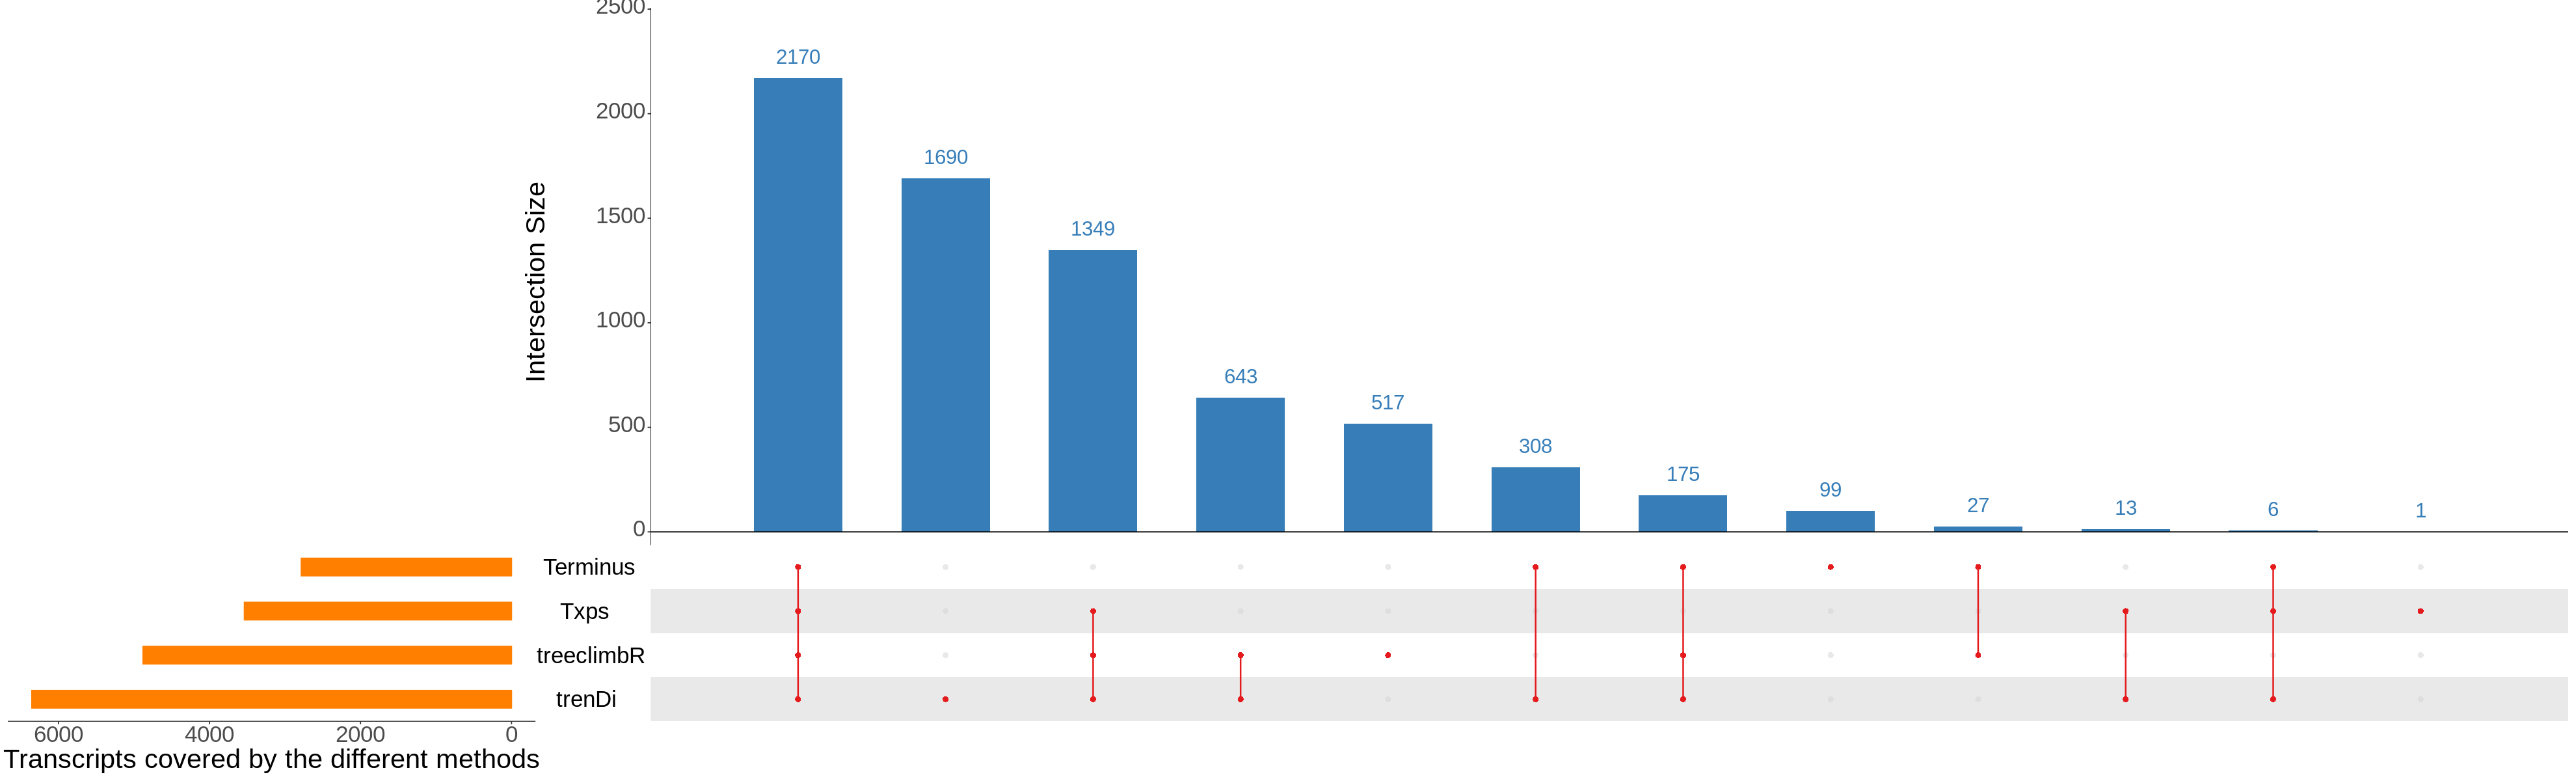

In [11]:
options(repr.plot.width=33, repr.plot.height=10)
suppressPackageStartupMessages(library(UpSetR))
txpMethods = list(Txps = rownames(tseChimp)[detNodes[["Txps"]][[j]]], 
                 trenDi = treeDETxps, 
                 treeclimbR = treeClimbTxps, 
                 Terminus = termTxps
                 )
upsetData <- fromList(txpMethods)
size <- 3
upset(upsetData, order.by = "freq",
     main.bar.color = "#377eb8", 
     matrix.color = "#e41a1c",
     sets.bar.color = c("#ff7f00"),
     sets.x.label = "Transcripts covered by the different methods",
     shade.alpha = 0.7, 
     text.scale = c(size, size, size, size, size, size)
)

#### Genes that map only to treeDE but are neither DE or covered by differential transcripts

In [17]:
### Nodes that dont cotain a DET
ll <- lapply(seq_along(treeDE), function(i) {
    desc <- Descendants(treeCons, treeDE[[i]])
    which(sapply(desc, function(txps) sum(txps %in% detNodes[["Txps"]][[i]]) == 0))
})

### Nodes that dont contain a single DE gene
sapply(ll, length)
nodesNotDE <- lapply(seq_along(ll), function(i) {
    genesL <- genesTreeDE[[i]][ll[[i]]]
    ll[[i]][sapply(genesL, function(genes) sum(genes %in% dges[[i]]) == 0)]
})
sapply(nodesNotDE, length)

[1] 485 318 365

[1] 31 59 76

Such inner nodes can be possible DTUs. We thus extract the treeDE nodes to which these genes map to and try to see if there are multiple such tree DE nodes that map to same gene.Looking at the 0.05 threshold change, we find only 0 gene for which a dtu on the inner nodes is observed.

For the remaining that have map to inner node, infRV decreases compared to their children though the logFC is lower compared to children. logFC though definitely decreases at gene.

In [31]:
qval <- 0.01
i <- 1
gg <- unlist(genesTreeDE[[i]][nodesNotDE[[i]]])
gN <- gg[which(mcols(yg)[gg,"qvalue"] > qval)]
length(gN) ## genes belonging to the unique treeDE nodes that have qvalue > 0.15 when doing gene level DE analysis

# extracting genes unique to treeDE and have logFC > 0.2 or have atleast two sig nodes
twoNodes <- list() 
lfcNodes <- c()
j <- 1
for(g in gN) {
    iid <- which(sapply(genesTreeDE[[i]], function(genes) sum(g %in%  genes) > 0))
    if(length(iid) > 1) {
        twoNodes[[j]] <- iid
        j <- j + 1
    }
    else if(length(which(abs(mcols(yAll)[treeDE[[i]][iid],"log2FC"]) > 0.2)) > 0) {
        lfcNodes <- c(lfcNodes, iid)
    }
}
length(twoNodes)
length(lfcNodes)

[1] 38

[1] 2

[1] 36

In [48]:
mcols(yg)[unlist(mapDf[treeCons$tip[treeDE[[i]][twoNodes[[2]]][2]],"GENEID"]),]
mcols(yAll)[treeDE[[i]][twoNodes[[2]]],]
mcols(yg)[unlist(mapDf[treeCons$tip[treeDE[[i]][twoNodes[[1]]][2]],"GENEID"]),]
mcols(yAll)[treeDE[[i]][twoNodes[[1]]],]

DataFrame with 1 row and 14 columns
                              gene_id   gene_name  entrezid   gene_biotype
                          <character> <character> <integer>    <character>
ENSPTRG00000049937 ENSPTRG00000049937      GABBR1        NA protein_coding
                   seq_coord_system      symbol
                          <integer> <character>
ENSPTRG00000049937               NA      GABBR1
                                                                         tx_ids
                                                                <CharacterList>
ENSPTRG00000049937 ENSPTRT00000091363,ENSPTRT00000095505,ENSPTRT00000100639,...
                   log10mean      keep      stat    log2FC     pvalue    locfdr
                   <numeric> <logical> <numeric> <numeric>  <numeric> <numeric>
ENSPTRG00000049937   4.17833      TRUE     11.41  0.392785 0.00495595 0.0688578
                      qvalue
                   <numeric>
ENSPTRG00000049937 0.0123066

DataFrame with 2 rows and 10 columns
                                 TXNAME             GENEID log10mean      keep
                            <character>        <character> <numeric> <logical>
Node55814                     Node55814                  2   3.47261      TRUE
ENSPTRT00000100639.1 ENSPTRT00000100639 ENSPTRG00000049937   4.05322      TRUE
                          stat    log2FC      pvalue      locfdr      qvalue
                     <numeric> <numeric>   <numeric>   <numeric>   <numeric>
Node55814                -12.5 -1.368861 2.00196e-07 4.33513e-06 1.09745e-06
ENSPTRT00000100639.1      12.5  0.836188 2.00196e-07 4.33513e-06 1.09745e-06
                     meanInfRV
                     <numeric>
Node55814             23.23067
ENSPTRT00000100639.1   8.34426

DataFrame with 1 row and 14 columns
                              gene_id   gene_name  entrezid   gene_biotype
                          <character> <character> <integer>    <character>
ENSPTRG00000012914 ENSPTRG00000012914        PNKD        NA protein_coding
                   seq_coord_system      symbol
                          <integer> <character>
ENSPTRG00000012914               NA        PNKD
                                                                         tx_ids
                                                                <CharacterList>
ENSPTRG00000012914 ENSPTRT00000023940,ENSPTRT00000078659,ENSPTRT00000087802,...
                   log10mean      keep      stat    log2FC    pvalue    locfdr
                   <numeric> <logical> <numeric> <numeric> <numeric> <numeric>
ENSPTRG00000012914    3.2519      TRUE    -10.66 -0.515557 0.0100797  0.132595
                      qvalue
                   <numeric>
ENSPTRG00000012914 0.0220411

DataFrame with 2 rows and 10 columns
                                 TXNAME             GENEID log10mean      keep
                            <character>        <character> <numeric> <logical>
Node51244                     Node51244                  2   3.01807      TRUE
ENSPTRT00000078659.1 ENSPTRT00000078659 ENSPTRG00000012914   2.79964      TRUE
                          stat    log2FC      pvalue      locfdr      qvalue
                     <numeric> <numeric>   <numeric>   <numeric>   <numeric>
Node51244                 12.5  0.638385 2.00196e-07 4.33513e-06 1.09745e-06
ENSPTRT00000078659.1     -12.5 -0.911412 2.00196e-07 4.33513e-06 1.09745e-06
                     meanInfRV
                     <numeric>
Node51244            0.0635942
ENSPTRT00000078659.1 0.1494380

#### Genes belonging to treeDE nodes that intersect with differentially expressed genes but are not covered by transcripts.'
We see many such genes that contain differential nodes but no differentially expressed transcripts. The magnitude of logFC in most cases though decreases from trancript to gene.

In [50]:
treeDECommonInds <- lapply(seq_along(genesTreeDE), function(i) {
    which(sapply(genesTreeDE[[i]], function(gs) sum(gs %in% diffGenes[[i]]) > 0))
})
sapply(treeDECommonInds,length)
save(treeDECommonInds, file="treeDE_Paper_Images/ChimpBrain/treeDECommonInds.RData")

[1] 407 194 213